Found 878 images belonging to 3 classes.
Found 219 images belonging to 3 classes.
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training DenseNet201...
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.7194 - loss: 1.0813 - val_accuracy: 0.8265 - val_loss: 0.5808
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.9217 - loss: 0.2201 - val_accuracy: 0.7078 - val_loss: 0.7544
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.9317 - loss: 0.1784 - val_accuracy: 0.7489 - val_loss: 0.6972
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.9369 - loss: 0.1486 - val_accuracy: 0.7763 - val_loss: 0.7694
Epoch 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - accuracy: 0.9466 - loss: 0.1240 - val_accuracy: 0.7900 - val_loss: 0.7605
Training EfficientNetB7...
Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.4562 - loss: 1.1940 - val_accuracy: 0.5114 - val_loss: 0.9958
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 321ms/step - accuracy: 0.4874 - loss: 0.9911 - val_accuracy: 0.5114 - val_loss: 0.9517
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 331ms/step - accuracy: 0.4963 - loss: 0.9721 - val_acc

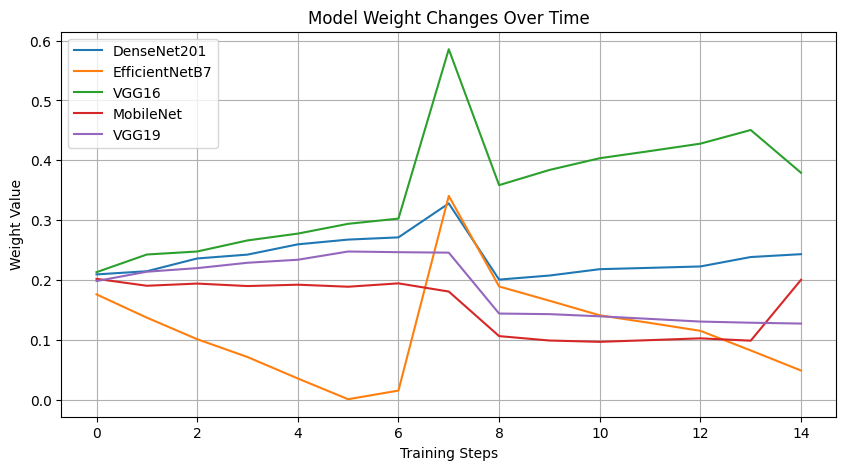

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import DenseNet201, EfficientNetB7, VGG16, MobileNet, VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, confusion_matrix

# Dataset Path
dataset_path = "/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset"

# Image Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

# Data Augmentation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Create Pretrained Model
def create_model(base_model):
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(3, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=x)

# Initialize models with pretrained weights
models = {
    "DenseNet201": create_model(DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))),
    "EfficientNetB7": create_model(EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))),
    "VGG16": create_model(VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))),
    "MobileNet": create_model(MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))),
    "VGG19": create_model(VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
}

# Train Models
for name, model in models.items():
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(f"Training {name}...")
    model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)
    model.save(f"{name}_model.h5")

# Load Trained Models
trained_models = {name: tf.keras.models.load_model(f"{name}_model.h5") for name in models.keys()}

# RL-Based Ensemble Class
class RL_Ensemble:
    def __init__(self, models, learning_rate=0.1, epsilon=0.1, gamma=0.9):
        self.models = models
        self.weights = np.ones(len(models)) / len(models)  # Start with equal weights
        self.learning_rate = learning_rate  # How fast to learn
        self.epsilon = epsilon  # Exploration rate
        self.gamma = gamma  # Discount factor for past experiences
        self.memory = []  # Store previous learning experiences
        self.history = []  # Store weight changes for visualization

    def predict(self, image):
        """
        Predict class using weighted ensemble
        """
        predictions = np.zeros((1, 3))
        for i, (name, model) in enumerate(self.models.items()):
            pred = model.predict(image, verbose=0)  # Suppress prediction logs
            predictions += pred * self.weights[i]
        return np.argmax(predictions, axis=1)

    def update_weights(self, X_val, y_val):
        """
        Update weights using reinforcement learning based on accuracy rewards
        """
        individual_acc = []
        for name, model in self.models.items():
            y_pred = np.argmax(model.predict(X_val, verbose=0), axis=1)
            acc = accuracy_score(y_val, y_pred)
            individual_acc.append(acc)

        # Compute rewards: how much better a model performed
        best_acc = max(individual_acc)
        rewards = np.array([acc - best_acc for acc in individual_acc])

        # Q-learning update rule
        for i in range(len(self.models)):
            self.weights[i] += self.learning_rate * (rewards[i] + self.gamma * np.max(rewards) - self.weights[i])

        # Exploration: Random weight adjustments
        if np.random.rand() < self.epsilon:
            self.weights += np.random.normal(0, 0.1, size=len(self.models))

        # Normalize weights
        self.weights = np.abs(self.weights) / np.sum(self.weights)

        print(f"Updated Weights: {self.weights}")

        # Store history for visualization
        self.history.append(self.weights.copy())

        # Store past experiences
        self.memory.append((X_val, y_val, self.weights))

    def experience_replay(self):
        """
        Replay past learning experiences for better reinforcement
        """
        if len(self.memory) > 0:  # Lowered threshold to replay with any experience
            X_sample, y_sample, _ = self.memory[np.random.randint(0, len(self.memory))]
            self.update_weights(X_sample, y_sample)

    def plot_weight_changes(self):
        """
        Visualize how the model learns and adjusts weights over time
        """
        plt.figure(figsize=(10, 5))
        weights_array = np.array(self.history)
        for i, model_name in enumerate(self.models.keys()):
            plt.plot(weights_array[:, i], label=f"{model_name}")
        plt.xlabel("Training Steps")
        plt.ylabel("Weight Value")
        plt.title("Model Weight Changes Over Time")
        plt.legend()
        plt.grid(True)  # Added grid for better readability
        plt.show()

# Create RL-based Ensemble
rl_ensemble = RL_Ensemble(trained_models)

# Load a Test Image for Prediction
def preprocess_image(image_path):
    image = load_img(image_path, target_size=IMG_SIZE)
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    return image

# Example Test Image
image_path = "/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (100).jpg"
test_image = preprocess_image(image_path)
prediction = rl_ensemble.predict(test_image)

class_names = ['Benign', 'Malignant', 'Normal']
print(f"Predicted Class: {class_names[prediction[0]]}")

# Update Weights Based on Validation Performance
# Perform multiple updates to ensure the graph has enough data points
num_updates = 10  # Number of weight updates for visualization
for step in range(num_updates):
    print(f"Weight Update Step {step + 1}/{num_updates}")
    X_val, y_val = next(val_generator)  # Get a new batch of validation data
    rl_ensemble.update_weights(X_val, np.argmax(y_val, axis=1))

# Perform Experience Replay
num_replays = 5  # Number of experience replay steps
for step in range(num_replays):
    print(f"Experience Replay Step {step + 1}/{num_replays}")
    rl_ensemble.experience_replay()

# Show Learning Progress
rl_ensemble.plot_weight_changes()